# Import Libraries & Packages

In [2]:
import pandas as pd
import dask.dataframe as dd
import seaborn as sns

In [3]:
import sys
sys.path.append('../lending_club')
import config

# Import Split File by Year

In [4]:
accepted_2015 = pd.read_parquet('../data/accepted-2015.parquet', engine='fastparquet')
accepted_2016 = pd.read_parquet('../data/accepted-2016.parquet', engine='fastparquet')
accepted_2017 = pd.read_parquet('../data/accepted-2017.parquet', engine='fastparquet')
accepted_2018 = pd.read_parquet('../data/accepted-2018.parquet', engine='fastparquet')

In [5]:
dfs = [accepted_2015, accepted_2016, accepted_2017, accepted_2018]

df = pd.concat(dfs)

# Clean Data HAD ISSUES

In [ ]:
from data_prep import clean
df = clean(df)

In [ ]:
df = df.dropna(subset = ['issue_d'])

In [ ]:
sum(df['id'].isnull())

# Feature Engineering

In [46]:
# My columns
df = df[['hardship_amount',
'hardship_dpd',
'hardship_end_date',
'hardship_flag',
'hardship_last_payment_amount',
'hardship_length',
'hardship_loan_status',
'hardship_payoff_balance_amount',
'hardship_reason',
'hardship_start_date',
'hardship_status',
'hardship_type',
'home_ownership',
'il_util',
'initial_list_status',
'inq_fi',
'inq_last_12m',
'inq_last_6mths',
'installment',
'int_rate',
'issue_d',
'last_credit_pull_d',
'last_fico_range_high',
'last_fico_range_low',
'last_pymnt_amnt',
'last_pymnt_d',
'loan_amnt',
'loan_status',
'max_bal_bc']]

# Columns to Drop

In [47]:
# Dropped red columns

df.drop([
    'hardship_amount',
    'hardship_dpd',
    'hardship_end_date',
    'hardship_flag',
    'hardship_last_payment_amount',
    'hardship_length',
    'hardship_loan_status',
    'hardship_payoff_balance_amount',
    'hardship_reason',
    'hardship_start_date',
    'hardship_status',
    'hardship_type',
    'installment',
    'last_credit_pull_d',
    'last_fico_range_high',
    'last_fico_range_low',
    'last_pymnt_amnt',
    'last_pymnt_d',
], axis = 1, inplace = True)

C:\Users\David\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
df['max_bal_bc'].corr(df['revol_bal'])

In [29]:
df['inq_last_12m'].corr(df['inq_fi'])

0.5564709751660746

In [49]:
# Dropped due to correlation

df.drop([
    'max_bal_bc'
], axis = 1, inplace = True)


In [50]:
# Dropped due to too many NA's (38%)

df.drop([
    'inq_fi',
    'inq_last_12m'
], axis = 1, inplace = True)


# Fill numerical NA's

* Mode imputation: inq_last_6mths

In [51]:
df['inq_last_6mths'].value_counts()

0.0    1140201
1.0     454221
2.0     142378
3.0      43880
4.0      10137
5.0       3462
6.0         43
Name: inq_last_6mths, dtype: int64

In [52]:
df['inq_last_6mths'].fillna(0, inplace = True)

C:\Users\David\anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


* Mean imputation: il_util

In [53]:
df['il_util'].value_counts()

78.0     22659
75.0     22425
81.0     22330
83.0     22286
72.0     22023
         ...  
259.0        1
293.0        1
225.0        1
261.0        1
262.0        1
Name: il_util, Length: 280, dtype: int64

[(0.0, 400.0)]

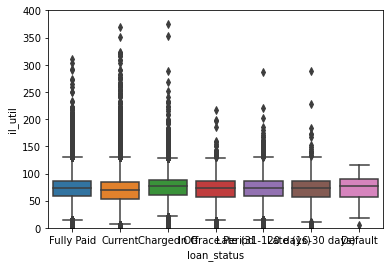

In [54]:
sns.boxplot(x = 'loan_status', y = 'il_util', data = df).set(ylim = (0,400))

In [55]:
df['il_util'].fillna(df['il_util'].mean(), inplace = True)

C:\Users\David\anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


# Dummify

In [56]:
pd.get_dummies(df['home_ownership'])

,ANY,MORTGAGE,NONE,OWN,RENT
0,0,1,0,0,0
1,0,1,0,0,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0
...,...,...,...,...,...
40165,0,1,0,0,0
40166,0,0,0,0,1
40167,0,1,0,0,0
40168,0,0,0,0,1


In [58]:
#Categorical
dummies=['home_ownership','initial_list_status']

for d in dummies:
    temp = pd.get_dummies(df[d], prefix=d, prefix_sep='__')
    temp = temp.drop(d+'__'+str(df[d].mode()[0]), axis=1)
    #drop the most common one (mode), making it the base case
    df = pd.concat([df.drop(d, axis=1),temp], axis=1)
    #merge back with main df

# Label Encoding Target Variable: loan_status

In [60]:
df['loan_status'].value_counts()

Current               866392
Fully Paid            702191
Charged Off           192060
Late (31-120 days)     21130
In Grace Period         8235
Late (16-30 days)       4276
Default                   39
Name: loan_status, dtype: int64

In [61]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [62]:
df['loan_status'] = le.fit_transform(df['loan_status'])

In [63]:
df['loan_status'].value_counts()

1    866392
3    702191
0    192060
6     21130
4      8235
5      4276
2        39
Name: loan_status, dtype: int64

# Test NA's

In [65]:
df.isnull().any()

il_util                   False
inq_last_6mths            False
int_rate                  False
issue_d                   False
loan_amnt                 False
loan_status               False
home_ownership__ANY       False
home_ownership__NONE      False
home_ownership__OWN       False
home_ownership__RENT      False
initial_list_status__f    False
dtype: bool